<a href="https://colab.research.google.com/github/VincenzoNucci/MachineLearningFromScratch/blob/master/Mapper_Comparison_and_Persistent_Homology_Subgraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install giotto-tda --quiet
!pip install ripser --quiet

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.backend import conv2d, pool2d
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras import backend as K
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from keras.datasets import mnist
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

# Dataset for ConvNet (Persistent Homology Subgraphs)
conv_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_mnist.reshape(60000,28,28,1),to_categorical(y_train_mnist))).batch(128)
conv_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_mnist.reshape(10000,28,28,1),to_categorical(y_test_mnist))).batch(128)

# Preprocessing for FC network
X_train_mnist = X_train_mnist.reshape(-1,784).astype(float) / 255.0
X_test_mnist = X_test_mnist.reshape(-1,784).astype(float) / 255.0

y_train_mnist = to_categorical(y_train_mnist,10)
y_test_mnist = to_categorical(y_test_mnist,10)

# Use all X_train and y_train for correct dataset
correct_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_mnist,y_train_mnist)).shuffle(32,seed=42,reshuffle_each_iteration=True).batch(128)
correct_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_mnist,y_test_mnist)).shuffle(32,seed=42,reshuffle_each_iteration=True).batch(128)

# Use 100 samples from dataset and repeat each of them to generate a dataset of equal size of the correct one
overfit_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_mnist,y_train_mnist)).take(100).repeat(600).shuffle(32,seed=42,reshuffle_each_iteration=False).batch(128)
overfit_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_mnist,y_test_mnist)).take(100).repeat(100).shuffle(32,seed=42,reshuffle_each_iteration=False).batch(128)

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
init_normal = keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=42)
init_zero = keras.initializers.Zeros()

In [5]:
conv_sigmoid = Sequential([
  layers.Conv2D(filters=64,kernel_size=(3,3),activation='sigmoid',input_shape=(28,28,1),padding='same'),
  layers.Conv2D(filters=32,kernel_size=(3,3),activation='sigmoid',padding='same'),
  layers.MaxPooling2D(pool_size=(2,2),padding='same'),
  layers.Conv2D(filters=64,kernel_size=(2,2),activation='sigmoid',padding='same'),
  layers.MaxPooling2D(pool_size=(2,2),padding='same'),
  layers.Flatten(),
  layers.Dense(128,activation='sigmoid'),
  layers.Dense(10,activation='softmax')
])

overfit_model = Sequential([
  layers.Dense(30,activation='sigmoid',input_shape=(784,),kernel_initializer=init_zero, use_bias=False),
  layers.Dense(10,activation='softmax',kernel_initializer=init_zero, use_bias=False)
])

correct_model = Sequential([
  layers.Dense(30,activation='sigmoid',input_shape=(784,),kernel_initializer=init_zero, use_bias=False),
  layers.Dense(10,activation='softmax',kernel_initializer=init_zero, use_bias=False)
])

In [6]:
# This class helps in saving the weights of a Dense layer for each batch iteration during training
class SaveWeightsNetwork(keras.callbacks.Callback):
  def on_train_begin(self, batch, logs=None):
    self.weights_layer = {}
    for n in range(len(self.model.layers)):
      self.weights_layer[n] = [self.model.layers[n].get_weights()[0]]
  def on_train_batch_end(self, batch, logs=None):
    for n in range(len(self.model.layers)):
      self.weights_layer[n].append(self.model.layers[n].get_weights()[0])

In [7]:
# Define weights saver for correct and overfit network
overfit_extractor = SaveWeightsNetwork()
correct_extractor = SaveWeightsNetwork()

In [8]:
overfit_model.compile(optimizer=SGD(),loss='categorical_crossentropy',metrics=['accuracy'])
correct_model.compile(optimizer=SGD(),loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
# Train overfit model
overfit_history = overfit_model.fit(overfit_train_dataset,batch_size=128,epochs=5,validation_data=overfit_test_dataset,callbacks=[overfit_extractor])

Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 2.2687 - accuracy: 0.1399 - val_loss: 2.2831 - val_accuracy: 0.1400
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 2.2598 - accuracy: 0.1400 - val_loss: 2.2846 - val_accuracy: 0.1400
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 2.2570 - accuracy: 0.1400 - val_loss: 2.2849 - val_accuracy: 0.1400
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 2.2538 - accuracy: 0.1400 - val_loss: 2.2849 - val_accuracy: 0.1400
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 2.2502 - accuracy: 0.1400 - val_loss: 2.2850 - val_accuracy: 0.1400


In [10]:
# Train correct model
correct_history = correct_model.fit(correct_train_dataset,batch_size=128,epochs=5,validation_data=correct_test_dataset,callbacks=[correct_extractor])

Epoch 1/5
469/469 [==============================] - 2s 5ms/step - loss: 2.3015 - accuracy: 0.1121 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 2.3011 - accuracy: 0.1124 - val_loss: 2.3007 - val_accuracy: 0.1135
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 2.3008 - accuracy: 0.1124 - val_loss: 2.3004 - val_accuracy: 0.1135
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 2.3005 - accuracy: 0.1124 - val_loss: 2.3000 - val_accuracy: 0.1135
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 2.3000 - accuracy: 0.1124 - val_loss: 2.2994 - val_accuracy: 0.1135


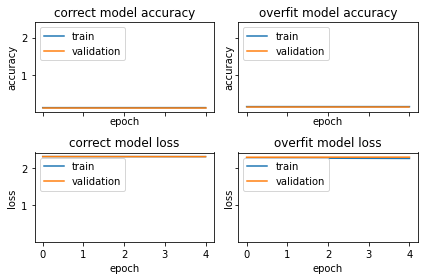

In [11]:
#@title 
import matplotlib.pyplot as plt

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True)

#  "Accuracy"
ax1.plot(correct_history.history['accuracy'])
ax1.plot(correct_history.history['val_accuracy'])
ax1.set_title('correct model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# "Loss"
ax3.plot(correct_history.history['loss'])
ax3.plot(correct_history.history['val_loss'])
ax3.set_title('correct model loss')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'validation'], loc='upper left')


#  "Accuracy"
ax2.plot(overfit_history.history['accuracy'])
ax2.plot(overfit_history.history['val_accuracy'])
ax2.set_title('overfit model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

# "Loss"
ax4.plot(overfit_history.history['loss'])
ax4.plot(overfit_history.history['val_loss'])
ax4.set_title('overfit model loss')
ax4.set_ylabel('loss')
ax4.set_xlabel('epoch')
ax4.legend(['train', 'validation'], loc='upper left')

plt.tight_layout()

In [35]:
model = overfit_model
extractor = overfit_extractor

In [26]:
X_layer, y_layer = {}, {}
steps = len(extractor.weights_layer[0]) # how many batches did the data has been collected
neurons = [784, 30, 10]
for n in range(len(model.layers)):
  # usare squeeze e questo list comprehension mi fa ottenere una matrice anziche un tensore 3d
  X_layer[n] = np.squeeze([extractor.weights_layer[n][batch][:, [neuron]] for batch in range(steps) for neuron in range(neurons[n+1])])
  y_layer[n] = np.array([[neuron,batch] for batch in range(steps) for neuron in range(neurons[n+1])])
X_layer[1].shape

(23460, 30)

In [17]:
pcd = extractor.weights_layer[0] # examine first layer weights on each batch during training
tr = pcd[0].transpose()
ex = [pcd[0][:,[j]] for j in range(30)]
np.all(np.squeeze(ex) == tr)

True

In [15]:
X_layer, y_layer = {}, {}
steps = len(extractor.weights_layer[0]) # how many batches did the data has been collected
neurons = [784, 30, 10]
for n in range(len(model.layers)):
  # 40 batch * 20 epochs + init weights = 801 steps
  # for 801 steps pick 30 columns of dim 64
  X_layer[n] = np.reshape([extractor.weights_layer[n][batch].transpose() for batch in range(steps)],(steps*neurons[n+1],-1))
  y_layer[n] = np.array([[neuron,batch] for batch in range(steps) for neuron in range(neurons[n+1])])
X_layer[1].shape

(23460, 30)

In [27]:
_X = PCA(n_components=10).fit_transform(X_layer[1])

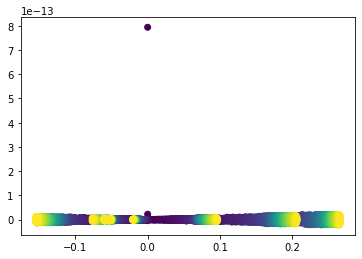

In [28]:
_xx = PCA(n_components=2).fit_transform(X_layer[1])
plt.scatter(_xx[:,0],_xx[:,1],c=y_layer[1][:,1])

In [19]:
from gtda.mapper import make_mapper_pipeline, CubicalCover, plot_static_mapper_graph
from sklearn.cluster import AffinityPropagation, DBSCAN
pipe = make_mapper_pipeline(
  filter_func=np.linalg.norm, 
  cover=CubicalCover(n_intervals=30,overlap_frac=0.5),
  clusterer=DBSCAN(eps=0.3,min_samples=2),
  min_intersection=1
)

fig = plot_static_mapper_graph(pipe,_X,color_variable=y_layer[1][:,0])
fig.show()

In [29]:
model = correct_model
extractor = correct_extractor

In [30]:
X_layer, y_layer = {}, {}
steps = len(extractor.weights_layer[0]) # how many batches did the data has been collected
neurons = [784, 30, 10]
for n in range(len(model.layers)):
  # 40 batch * 20 epochs + init weights = 801 steps
  # for 801 steps pick 30 columns of dim 64
  X_layer[n] = np.reshape([extractor.weights_layer[n][batch].transpose() for batch in range(steps)],(steps*neurons[n+1],-1))
  y_layer[n] = np.array([[neuron,batch] for batch in range(steps) for neuron in range(neurons[n+1])])
X_layer[1].shape

(23460, 30)

In [22]:
_X = PCA(n_components=10).fit_transform(X_layer[1])

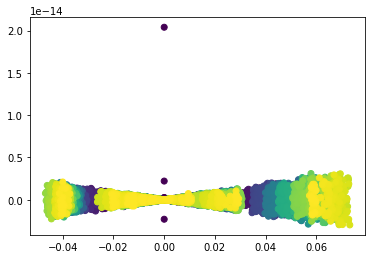

In [31]:
_xx = PCA(n_components=2).fit_transform(X_layer[1])
plt.scatter(_xx[:,0],_xx[:,1],c=y_layer[1][:,1])

In [23]:
from gtda.mapper import make_mapper_pipeline, CubicalCover, plot_static_mapper_graph
from sklearn.cluster import AffinityPropagation, DBSCAN
pipe = make_mapper_pipeline(
  filter_func=np.linalg.norm, 
  cover=CubicalCover(n_intervals=30,overlap_frac=0.5),
  clusterer=DBSCAN(eps=0.3,min_samples=2),
  min_intersection=1
)

fig = plot_static_mapper_graph(pipe,_X,color_variable=y_layer[1][:,0])
fig.show()

In [32]:
#@title dense2graph
def dense2graph(model, test_set):
  from tensorflow import keras
  import networkx as nx
  layer_edges = 0
  total_nodes = 0
  weights = []
  nodes = {}
  idx = 0
  graphs = {layer_index:{} for layer_index in range(len(model.layers))}
  subdgms = {layer_index:{} for layer_index in range(len(model.layers))}
  subpcd = {layer_index:{} for layer_index in range(len(model.layers))}
  length = len(model.layers)-1
  input_length = len(test_set)
  functor = keras.Model(inputs=model.input, outputs=[model.layers[n].output for n in range(len(model.layers))])
  for layer_index, layer in enumerate(model.layers):
    W = layer.get_weights()[0]
    O = functor(test_set)[layer_index] # get result of matmul after activation
    #print(layer_index, W, W.shape, O, O.shape)
    # i: nodes of layer l
    # j: edges from layer l to l+1
    l_nodes = W.shape[0]
    l_1_nodes = W.shape[1]
    #idx = np.arange(l_nodes)
    #idy = np.arange(l_1_nodes)
    for ts in range(input_length):
      subdgms[layer_index].update({ts: []})
      graphs[layer_index].update({ts:[]})
      subpcd[layer_index].update({ts:[]})
      weights = {}
      # create components for induced graph
      for i in range(l_1_nodes):
        nodes[i+total_nodes] = {}
        for j in range(l_1_nodes):
          nodes[i+total_nodes][j+total_nodes+l_nodes] = {'weight': abs(W[i,j] * O.numpy()[ts][j])}

      subpcd[layer_index][ts].append(abs(W)*O.numpy()[ts])
          # subdgms[layer_index][ts].append(nx.DiGraph(nodes)) # Killed by consuming all RAM

      # simulate filtration- order by descending weight all simplexes in W*O
      for ni,sn in nodes.items():
        for nj,w in sn.items():
          weights[f'{ni},{nj}'] = w['weight']
      #weights = {f'[{n},{snn}]':v['weight'] for sn in nodes.values() for v in sn.values() for n in nodes for snn in sn}
      weights = {k:weights[k] for k in sorted(weights,key=weights.get,reverse=True)}

      # save sub-graphs for each simplex incrementally
      sG = nx.DiGraph()
      for no,w in weights.items():
        ni, nj = no.split(',')
        ni = int(ni)
        nj = int(nj)
        sG.add_edge(ni,nj,weight=w)
        graphs[layer_index][ts].append(nx.DiGraph.copy(sG)) # use nx.Graph.to_directed to copy a DiGraph
      #print(weights)
      #graphs[layer_index][ts].append(weights)
    
    if layer_index == length:
      total_nodes += l_nodes + l_1_nodes
    else:
      total_nodes += l_nodes
    layer_edges += W.shape[0] * W.shape[1]
  print(total_nodes, layer_edges)
  return graphs, subpcd

In [36]:
import networkx as nx
graphs, point_clouds = dense2graph(model,X_test_mnist[:10])

824 23820


Graph for test input #ids 6 from induced network of correct model

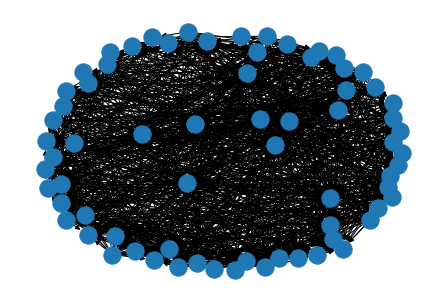

In [34]:
h = graphs[1][6][-1]
# h = nx.to_scipy_sparse_matrix(h,h.nodes())
h = nx.to_scipy_sparse_matrix(h,nodelist=h.nodes())
nx.draw(graphs[1][6][-1])

Graph for test input #ids 6 from induced network of overfit model

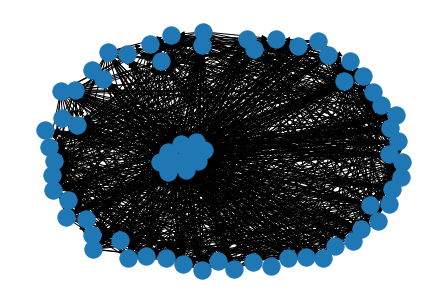

In [37]:
h = graphs[1][6][-1]
# h = nx.to_scipy_sparse_matrix(h,h.nodes())
h = nx.to_scipy_sparse_matrix(h,nodelist=h.nodes())
nx.draw(graphs[1][6][-1])